In [4]:
%pylab inline
from astropy.io import fits
import astropy.units as u
import pickle as pickle
import os as os
import pandas as pd

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples

Populating the interactive namespace from numpy and matplotlib


In [5]:
import spectools_ir
spectools_ir.__file__

'/Users/erichegonzales/opt/anaconda3/lib/python3.8/site-packages/spectools_ir/__init__.py'

# Compare Star Properties and Parameters 

In [11]:
data = pd.read_csv("/Users/erichegonzales/Desktop/eriche-thesis/data/star_data.csv")
#print(data)
data

,object,disk_type,parallax,distance,distance_au,solar_mass,solar_lum,solar_temp,spec_type,log_ntot,...,ntot_neg,temp,temp_pos,temp_neg,omega,omega_pos,omega_neg,col_density,disk_radius,disk_area
0,CI Tau,Transitional,6.23760,160.318071,33068006.93,0.92,0.93,4590,K4IVe C,22.919,...,-0.608,4122.296,2935.870,-1294.494,-16.558,0.395,-0.456,8.298510e+22,0.098137,0.030256
1,LkHa 330,Transitional,3.14250,318.217979,65637231.50,2.50,16.00,6280,F7 D,20.785,...,-0.082,899.705,26.184,-26.227,-15.434,0.066,-0.061,6.095370e+20,0.710518,1.585990
2,TW Hya,Transitional,16.62890,60.136269,12404007.48,0.70,0.25,4205,K6Ve C,20.683,...,-0.204,835.624,42.444,-43.071,-15.478,0.114,-0.085,4.819480e+20,0.127640,0.051183
3,DoAr 44,Transitional,6.83430,146.320764,30180852.46,1.40,1.40,4730,K3e D,21.600,...,-0.09,1371.252,74.348,-70.312,-16.065,0.066,-0.070,3.981070e+21,0.158000,0.078427
4,HD 135344,Transitional,7.41050,134.943661,27834154.24,1.80,6.80,9520,A0V C,20.904,...,-0.071,752.073,29.338,-30.845,-14.867,0.085,-0.077,8.016780e+20,0.578766,1.052340
5,UX Tau,Transitional,6.92270,144.452309,29795455.53,1.10,1.00,4900,K2Ve+M1Ve C,21.346,...,-0.159,942.864,58.936,-58.297,-16.505,0.157,-0.143,2.218200e+21,0.093989,0.027752
6,AB Aur,HAeBe,6.41270,155.940555,32165078.67,2.40,38.00,9772,A0Ve,21.535,...,-0.03,823.779,15.155,-15.409,-14.547,0.027,-0.025,3.427680e+21,0.966740,2.936089
7,HD144432,HAeBe,6.45810,154.844304,31938960.38,1.80,12.70,7220,A9/F0V,22.101,...,-0.157,629.278,53.108,-44.546,-14.941,0.153,-0.155,1.261830e+22,0.609882,1.168535
8,HD 36112,HAeBe,6.41570,155.867637,32150038.19,2.00,24.00,8128,A8Ve,21.190,...,-0.036,900.155,16.500,-16.531,-15.015,0.024,-0.025,1.548820e+21,0.563776,0.998534
9,GK Tau,Classical,7.74330,129.143905,26637867.58,0.79,0.80,4007,K7,21.838,...,-0.134,2305.279,181.446,-148.773,-16.355,0.102,-0.110,6.886520e+21,0.099868,0.031333


In [17]:
data_t = data.loc[data['disk_type'] == 'Transitional']
data_c = data.loc[data['disk_type'] == 'Classical']
data_h = data.loc[data['disk_type'] == 'HAeBe']


distance_t = data['distance_au'][data['disk_type'] == 'Transitional']
sol_mass_t = data['solar_mass'][data['disk_type'] == 'Transitional']
sol_lum_t = data['solar_lum'][data['disk_type'] == 'Transitional']
sol_temp_t = data['solar_temp'][data['disk_type'] == 'Transitional']
ntot_t = data['log_ntot'][data['disk_type'] == 'Transitional']
disk_temp_t = data['temp'][data['disk_type'] == 'Transitional']
solid_angle_t = data['omega'][data['disk_type'] == 'Transitional']
col_density_t = data['col_density'][data['disk_type'] == 'Transitional']
disk_radius_t = data['disk_radius'][data['disk_type'] == 'Transitional']
disk_area_t = data['disk_area'][data['disk_type'] == 'Transitional']


distance_c = data['distance_au'][data['disk_type'] == 'Classical']
sol_mass_c = data['solar_mass'][data['disk_type'] == 'Classical']
sol_lum_c = data['solar_lum'][data['disk_type'] == 'Classical']
sol_temp_c = data['solar_temp'][data['disk_type'] == 'Classical']
ntot_c = data['log_ntot'][data['disk_type'] == 'Classical']
disk_temp_c = data['temp'][data['disk_type'] == 'Classical']
solid_angle_c = data['omega'][data['disk_type'] == 'Classical']
col_density_c = data['col_density'][data['disk_type'] == 'Classical']
disk_radius_c = data['disk_radius'][data['disk_type'] == 'Classical']
disk_area_c = data['disk_area'][data['disk_type'] == 'Classical']


distance_h = data['distance_au'][data['disk_type'] == 'HAeBe']
sol_mass_h = data['solar_mass'][data['disk_type'] == 'HAeBe']
sol_lum_h = data['solar_lum'][data['disk_type'] == 'HAeBe']
sol_temp_h = data['solar_temp'][data['disk_type'] == 'HAeBe']
ntot_h = data['log_ntot'][data['disk_type'] == 'HAeBe']
disk_temp_h = data['temp'][data['disk_type'] == 'HAeBe']
solid_angle_h = data['omega'][data['disk_type'] == 'HAeBe']
col_density_h = data['col_density'][data['disk_type'] == 'HAeBe']
disk_radius_h = data['disk_radius'][data['disk_type'] == 'HAeBe']
disk_area_h = data['disk_area'][data['disk_type'] == 'HAeBe']

#(data.loc[data['disk_type'] == 'Transitional'])['solar_mass']

6    2.936089
7    1.168535
8    0.998534
Name: disk_area, dtype: float64


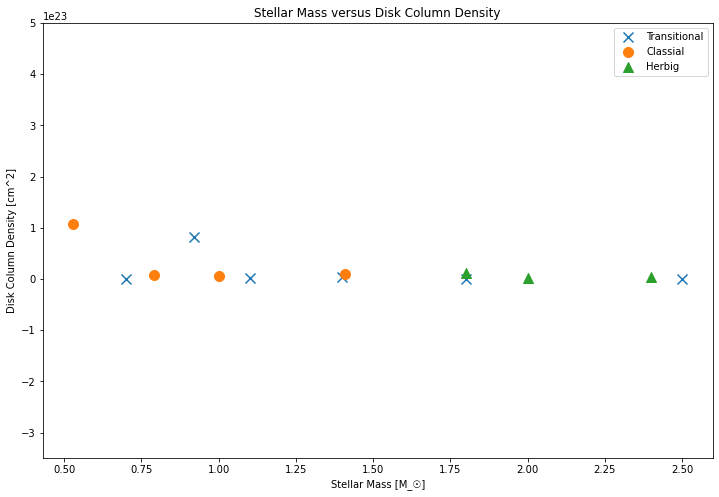

In [80]:
#1

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
ax1.scatter(sol_mass_t, col_density_t, label='Transitional', marker ='x', s=100)
ax1.scatter(sol_mass_c, col_density_c, label='Classial', marker ='o', s=100)
ax1.scatter(sol_mass_h, col_density_h, label='Herbig', marker ='^', s=100)

ax1.set_xlabel('Stellar Mass [M_☉]')
ax1.set_ylabel('Disk Column Density [cm^2]')
ax1.set_title('Stellar Mass versus Disk Column Density')
ax1.set_ylim(ymax = 0.5e24)
ax1.legend()
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

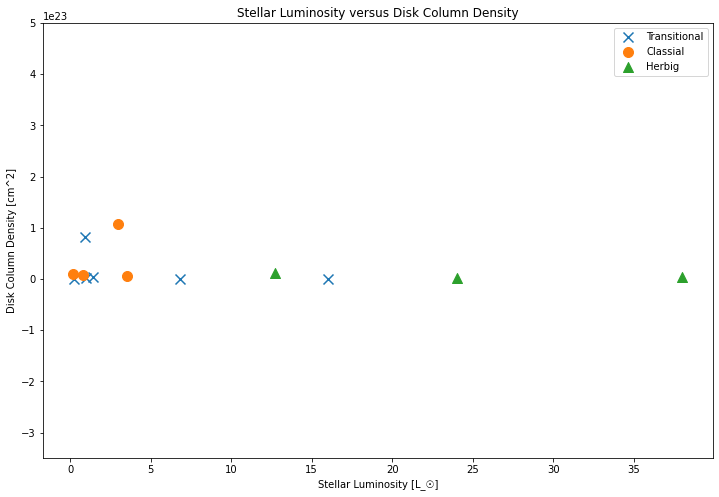

In [86]:
#2

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
ax1.scatter(sol_lum_t, col_density_t, label='Transitional', marker ='x', s=100)
ax1.scatter(sol_lum_c, col_density_c, label='Classial', marker ='o', s=100)
ax1.scatter(sol_lum_h, col_density_h, label='Herbig', marker ='^', s=100)

ax1.set_xlabel('Stellar Luminosity [L_☉]')
ax1.set_ylabel('Disk Column Density [cm^2]')
ax1.set_title('Stellar Luminosity versus Disk Column Density')
ax1.set_ylim(ymax = 0.5e24)
ax1.legend()
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

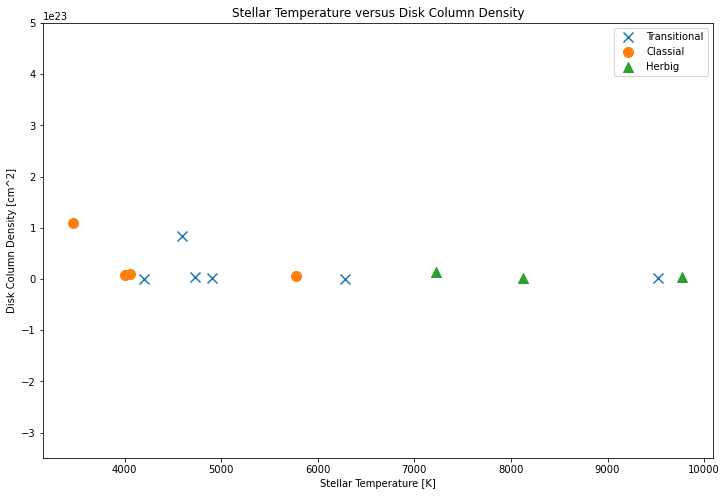

In [90]:
#3

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
ax1.scatter(sol_temp_t, col_density_t, label='Transitional', marker ='x', s=100)
ax1.scatter(sol_temp_c, col_density_c, label='Classial', marker ='o', s=100)
ax1.scatter(sol_temp_h, col_density_h, label='Herbig', marker ='^', s=100)

ax1.set_xlabel('Stellar Temperature [K]')
ax1.set_ylabel('Disk Column Density [cm^2]')
ax1.set_title('Stellar Temperature versus Disk Column Density')
ax1.set_ylim(ymax = 0.5e24)
ax1.legend()
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

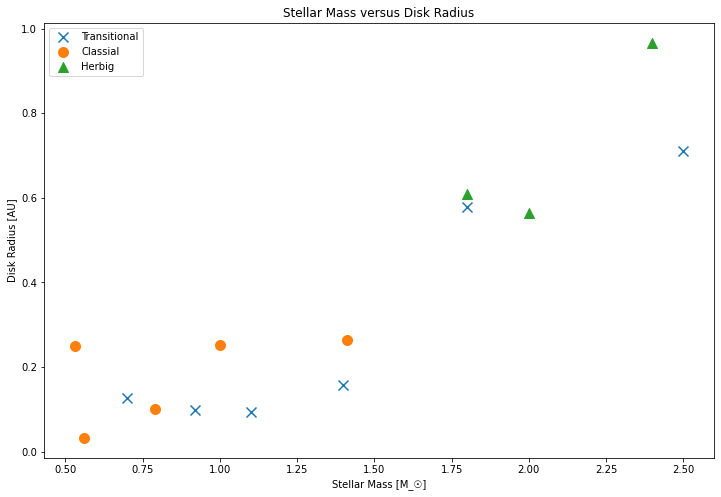

In [89]:
#4

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
ax1.scatter(sol_mass_t, disk_radius_t, label='Transitional', marker ='x', s=100)
ax1.scatter(sol_mass_c, disk_radius_c, label='Classial', marker ='o', s=100)
ax1.scatter(sol_mass_h, disk_radius_h, label='Herbig', marker ='^', s=100)

ax1.set_xlabel('Stellar Mass [M_☉]')
ax1.set_ylabel('Disk Radius [AU]')
ax1.set_title('Stellar Mass versus Disk Radius')
#ax1.set_ylim(ymax = 0.5e24)
ax1.legend()
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

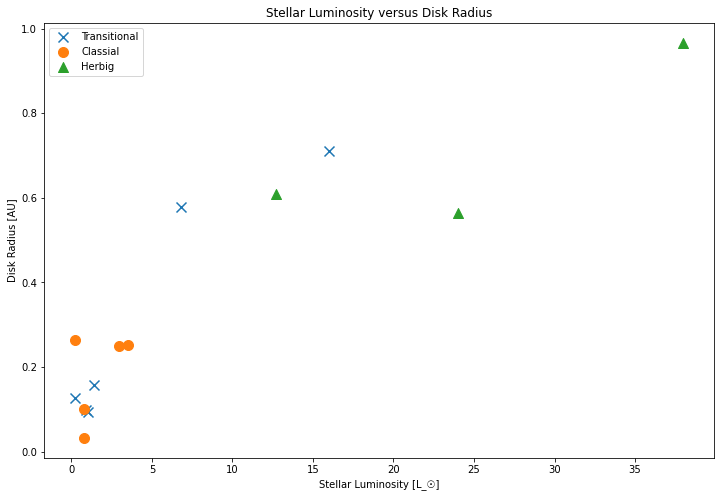

In [91]:
#5

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
ax1.scatter(sol_lum_t, disk_radius_t, label='Transitional', marker ='x', s=100)
ax1.scatter(sol_lum_c, disk_radius_c, label='Classial', marker ='o', s=100)
ax1.scatter(sol_lum_h, disk_radius_h, label='Herbig', marker ='^', s=100)

ax1.set_xlabel('Stellar Luminosity [L_☉]')
ax1.set_ylabel('Disk Radius [AU]')
ax1.set_title('Stellar Luminosity versus Disk Radius')
#ax1.set_ylim(ymax = 0.5e24)
ax1.legend()
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

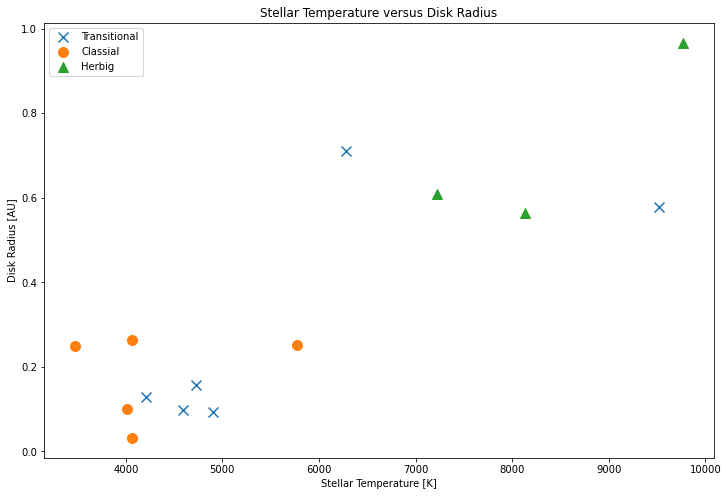

In [93]:
#6

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
ax1.scatter(sol_temp_t, disk_radius_t, label='Transitional', marker ='x', s=100)
ax1.scatter(sol_temp_c, disk_radius_c, label='Classial', marker ='o', s=100)
ax1.scatter(sol_temp_h, disk_radius_h, label='Herbig', marker ='^', s=100)

ax1.set_xlabel('Stellar Temperature [K]')
ax1.set_ylabel('Disk Radius [AU]')
ax1.set_title('Stellar Temperature versus Disk Radius')
#ax1.set_ylim(ymax = 0.5e24)
ax1.legend()
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

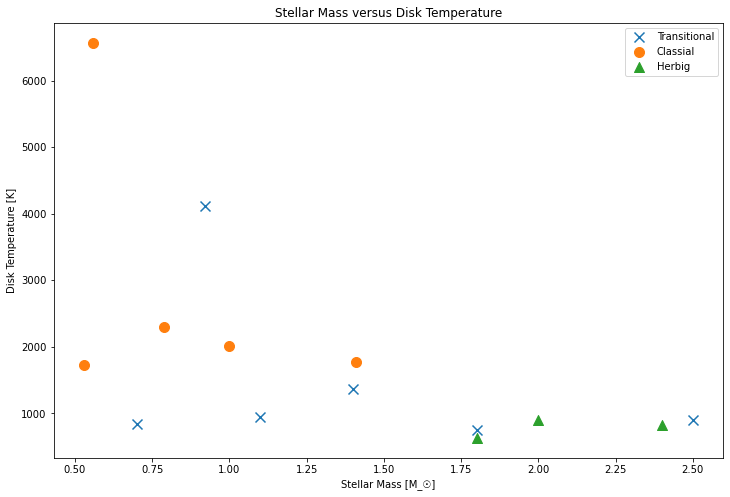

In [94]:
#7

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
ax1.scatter(sol_mass_t, disk_temp_t, label='Transitional', marker ='x', s=100)
ax1.scatter(sol_mass_c, disk_temp_c, label='Classial', marker ='o', s=100)
ax1.scatter(sol_mass_h, disk_temp_h, label='Herbig', marker ='^', s=100)

ax1.set_xlabel('Stellar Mass [M_☉]')
ax1.set_ylabel('Disk Temperature [K]')
ax1.set_title('Stellar Mass versus Disk Temperature')
#ax1.set_ylim(ymax = 0.5e24)
ax1.legend()
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

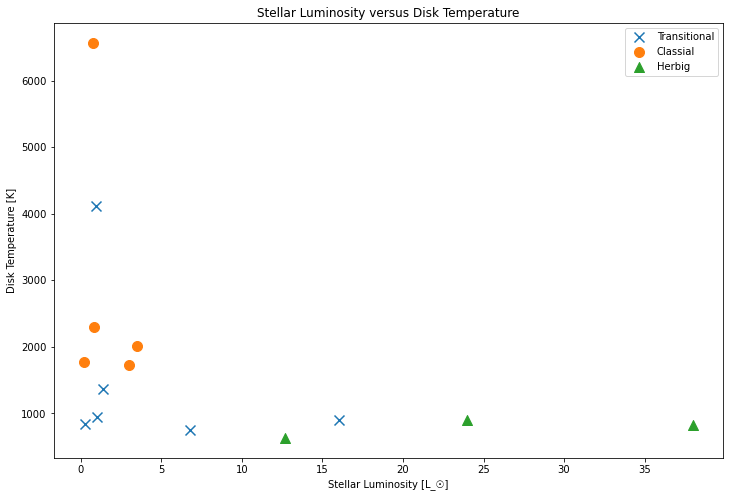

In [95]:
#8

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
ax1.scatter(sol_lum_t, disk_temp_t, label='Transitional', marker ='x', s=100)
ax1.scatter(sol_lum_c, disk_temp_c, label='Classial', marker ='o', s=100)
ax1.scatter(sol_lum_h, disk_temp_h, label='Herbig', marker ='^', s=100)

ax1.set_xlabel('Stellar Luminosity [L_☉]')
ax1.set_ylabel('Disk Temperature [K]')
ax1.set_title('Stellar Luminosity versus Disk Temperature')
#ax1.set_ylim(ymax = 0.5e24)
ax1.legend()
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

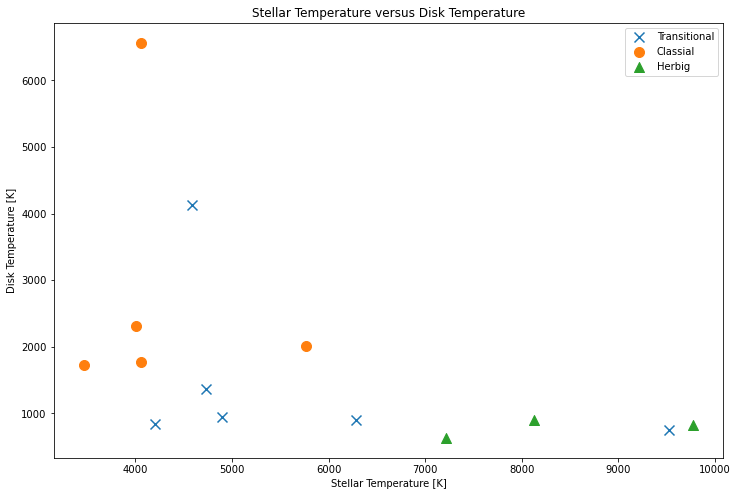

In [96]:
#9

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
ax1.scatter(sol_temp_t, disk_temp_t, label='Transitional', marker ='x', s=100)
ax1.scatter(sol_temp_c, disk_temp_c, label='Classial', marker ='o', s=100)
ax1.scatter(sol_temp_h, disk_temp_h, label='Herbig', marker ='^', s=100)

ax1.set_xlabel('Stellar Temperature [K]')
ax1.set_ylabel('Disk Temperature [K]')
ax1.set_title('Stellar Temperature versus Disk Temperature')
#ax1.set_ylim(ymax = 0.5e24)
ax1.legend()
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

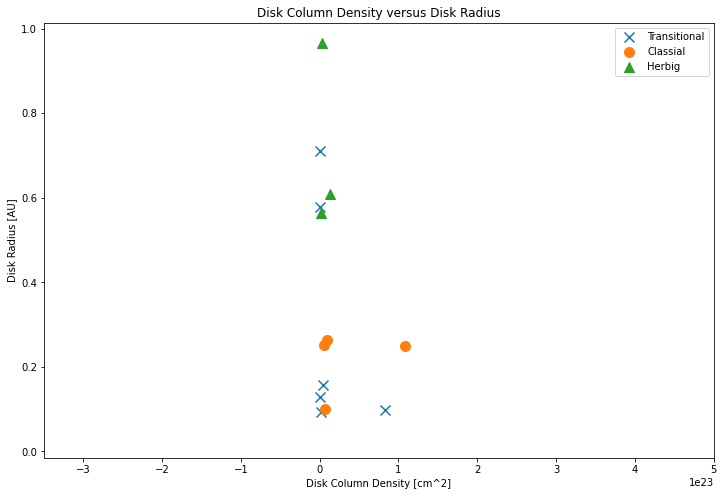

In [108]:
#10

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
ax1.scatter(col_density_t, disk_radius_t, label='Transitional', marker ='x', s=100)
ax1.scatter(col_density_c, disk_radius_c, label='Classial', marker ='o', s=100)
ax1.scatter(col_density_h, disk_radius_h, label='Herbig', marker ='^', s=100)

ax1.set_xlabel('Disk Column Density [cm^2]')
ax1.set_ylabel('Disk Radius [AU]')
ax1.set_title('Disk Column Density versus Disk Radius')
ax1.set_xlim(xmax = 0.5e24)
ax1.legend()
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

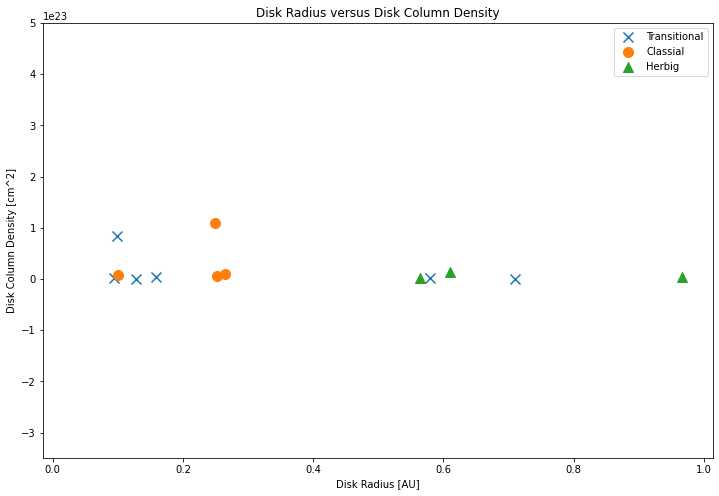

In [105]:
#10

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
ax1.scatter(disk_radius_t, col_density_t, label='Transitional', marker ='x', s=100)
ax1.scatter(disk_radius_c, col_density_c, label='Classial', marker ='o', s=100)
ax1.scatter(disk_radius_h, col_density_h, label='Herbig', marker ='^', s=100)

ax1.set_xlabel('Disk Radius [AU]')
ax1.set_ylabel('Disk Column Density [cm^2]')
ax1.set_title('Disk Radius versus Disk Column Density')
ax1.set_ylim(ymax = 0.5e24)
ax1.legend()
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

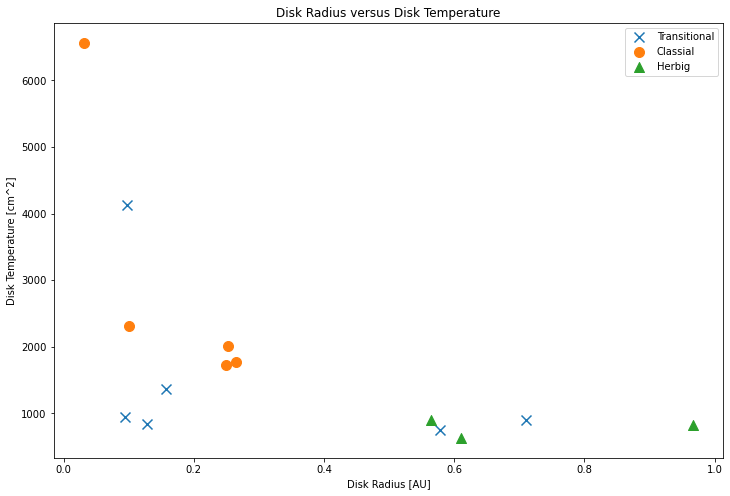

In [106]:
#11

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
ax1.scatter(disk_radius_t, disk_temp_t, label='Transitional', marker ='x', s=100)
ax1.scatter(disk_radius_c, disk_temp_c, label='Classial', marker ='o', s=100)
ax1.scatter(disk_radius_h, disk_temp_h, label='Herbig', marker ='^', s=100)

ax1.set_xlabel('Disk Radius [AU]')
ax1.set_ylabel('Disk Temperature [cm^2]')
ax1.set_title('Disk Radius versus Disk Temperature')
#ax1.set_ylim(ymax = 0.5e24)
ax1.legend()
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

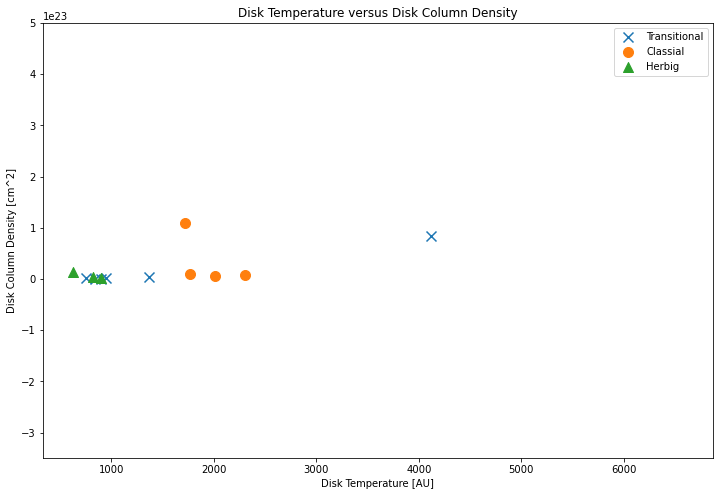

In [107]:
#12

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
ax1.scatter(disk_temp_t, col_density_t, label='Transitional', marker ='x', s=100)
ax1.scatter(disk_temp_c, col_density_c, label='Classial', marker ='o', s=100)
ax1.scatter(disk_temp_h, col_density_h, label='Herbig', marker ='^', s=100)

ax1.set_xlabel('Disk Temperature [AU]')
ax1.set_ylabel('Disk Column Density [cm^2]')
ax1.set_title('Disk Temperature versus Disk Column Density')
ax1.set_ylim(ymax = 0.5e24)
ax1.legend()
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)